# VAMPnets

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a><br><br>

In this session we will see an example of how to use VAMPnets to extract a coarse-grained model from raw data using a n unsupervised deep learning approach. We will load data from a 2D toy model with xxx states, and build and train a neural network that assigns each datapoint to a separate state, and finally visualize the information we extracted from the dataset. 
After this, we will follow the same process to analyse a trajectory of the molecule Alanine Dipeptide, since it is a 30D system whose dynamics can be easily visualized in a 2D space.


<a id="ref-1" href="https://www.nature.com/articles/s41467-017-02388-1">Here</a> you can find literature on the used method.

**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

### Import the required packages

In case you haven't installed tensorflow, you can do so through conda from the conda-forge channel, by running the following line in your conda shell:

`conda install -c conda-forge tensorflow`

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma
import tensorflow as tf
from tensorflow import keras
import helper_vampnets as vn

/storage/mi/pasquali/miniconda3/envs/pyemma_tutorials/lib/python3.7/site-packages/mdshare/repository.py:53: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = load(fh)


<IPython.core.display.Javascript object>

### Guided example: 2D toy model
We start by loading the data for the 2D model by using the package `mdshare`. The `fetch` function fetches the data from our servers. **Do not use `mdshare` for your own data!**

In [3]:
file = mdshare.fetch("hmm-doublewell-2d-100k.npz", working_directory="data")
with np.load(file) as fh:
    data = fh["trajectory"]

<IPython.core.display.Javascript object>

Next we want to visualize how the datas are distributed in the 2D space.

#### Exercise
Plot the density of the data using a function from the `pyemma` package

In [4]:
pyemma. ##FIXME
plt.show()

<IPython.core.display.Javascript object>

#### Solution

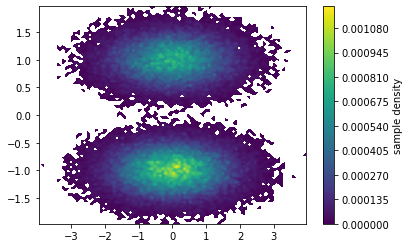

<IPython.core.display.Javascript object>

In [5]:
pyemma.plots.plot_density(*data.T, cmap="viridis")
plt.show()

### Hyperparameter selection
The next step is a bit tricky, as hyperparameter selection requires some experience to be done correctly. We provided some default values that will allow for a smooth training of our model. The meaning of every hyperparameter is explained in the next cell.

In [6]:
# Tau, how much is the timeshift of the two datasets
tau = 1

# Batch size for Stochastic Gradient descent
batch_size = 3000

# Which trajectory points percentage is used as training
train_ratio = 0.9

# How many hidden layers the network has
network_depth = 5

# "Width" of every layer
layer_width = 20

# Learning rate used for the ADAM optimizer
learning_rate = 1e-3

# How many output states the network has
output_size = 2

# Iteration over the training set in the fitting process;
# basically how many iterations our training algorithm will do
nb_epoch = 20

<IPython.core.display.Javascript object>

### Data preprocessing

Now we can to prepare our data so that it can be used for training our VAMPnets model. We want two arrays made of coupled datapoints, which are selected from the main trajectory at indexes $i, i+\tau$. We want the two trajectories to be shuffled, but to maintain the correspondence between the non-time-lagged and the time-lagged datapoints. Finally, we want to split our data into training set and validation set, the former being used for training the algorithm, and the latter being necessary to test whether the network is overfitting ( = the resulting transformation works only on the training set but not on data from the same distribution).
<br>
<br>
Note how we create an array of zeros at the end of the cell. This is necessary as the deep learning package we will use today sacrifices versatility in favour of a more simple interface, thus we have to pass it a set of labels for our data. While this is mandatory in supervised learning problems, VAMPnets are an unsupervised learning approach, thus we just use arrays of `0`'s as a fill-in.

In [7]:
# Split data into non-lagged and lagged array
traj_data_points, input_size = data.shape
length_traj = traj_data_points - tau

traj_ord = data[:-tau]
traj_ord_lag = data[tau:]

# Shuffle the two arrays according to the same random indexing
indexes = np.arange(length_traj)
np.random.shuffle(indexes)

traj = traj_ord[indexes]
traj_lag = traj_ord_lag[indexes]

# Split the two into training and validation sets
length_train = int(np.floor(length_traj * train_ratio))

X1_train_nw, X1_valid_nw = np.split(traj, [length_train])
X2_train_nw, X2_valid_nw = np.split(traj_lag, [length_train])

# Create the label arrays required by tf.keras
Y_train = np.zeros((X1_train_nw.shape[0], 2 * output_size))
Y_valid = np.zeros((X1_valid_nw.shape[0], 2 * output_size))

<IPython.core.display.Javascript object>

As a final preprocessing step, we remove the mean and variance from our datasets, a practice that usually makes the training easier. <br>**Note that since we will train the network using data transformed through this function, we will have to transform every new data we want to pass through the network in the same way!!**

In [8]:
# Calculate the mean and standard deviation of the joint dataset, and create a function that transforms those data
mean_train = np.concatenate([X1_train_nw, X2_train_nw]).mean(0)
std_train = np.concatenate([X1_train_nw, X2_train_nw]).std(0)

# Note: we pass the values that we have as default parameters in the function, so that if the numeric value of those
# variables is changed in the future, the function won't change
def whiten(x, mean=mean_train, std=std_train):
    return (x - mean) / std


# Whiten the datasets
X1_train = whiten(X1_train_nw)
X2_train = whiten(X2_train_nw)
X1_valid = whiten(X1_valid_nw)
X2_valid = whiten(X2_valid_nw)

<IPython.core.display.Javascript object>

### Implementation of the neural network
The following steps might be confusing if you have never worked with neural networks before, so please do not hesitate to ask any questions you might have about this phase.

In [9]:
# Magic function that removes all the variables stored in memory by the keras package
# It should be called before creating a new neural network as a safety measure
keras.backend.clear_session()

<IPython.core.display.Javascript object>

The first step in creating a neural network is the definition of the input layers, which are the ones that will accept our training data and feed it to the next layer. Note how we only need to define the input size of our dataset, but not the number of datapoints that we have; this is because the network can adapt to every number of training points (as long as we have enough physical memory).

In [10]:
Data_X1 = keras.layers.Input(shape=(input_size,))
Data_X2 = keras.layers.Input(shape=(input_size,))

<IPython.core.display.Javascript object>

Next we create a list of dense layers, one for every hidden layer in our desired network structure

In [11]:
nodes_list = [layer_width] * network_depth
dense_layers = []
for nodes in nodes_list:
    # Note: "elu" identifies a specific activation function that performs very well with vampnets
    dense_layers.append(keras.layers.Dense(nodes, activation="elu"))

<IPython.core.display.Javascript object>

The way to create a pipeline of layers is to call a layer on the previous one:
```
layer1 = keras.layers.Dense()  --> These are definitions of the layer
layer2 = keras.layers.Dense()  --> These are definitions of the layer

network = layer2(layer1(input))  --> Here we call each layer on the previous one, creating a network
```

Note how we defined each layer once, but we used on both the X1 and X2 "lobes" of the network; this ensures that the two datasets will be transformed using the same parameters.

In [12]:
lx_chi = Data_X1
rx_chi = Data_X2

for layer in dense_layers:

    lx_chi = layer(lx_chi)
    rx_chi = layer(rx_chi)

<IPython.core.display.Javascript object>

Finally we can add a `softmax` layer, which will give us the probabilistic encoding of the output, and merge the two networks.

In [13]:
softmax = keras.layers.Dense(output_size, activation="softmax")

lx_chi = softmax(lx_chi)
rx_chi = softmax(rx_chi)


merged = keras.layers.concatenate([lx_chi, rx_chi])

<IPython.core.display.Javascript object>

### Utilizing the network

At this point we are done creating the neural network, and we have to make a model out of our network, so that we can train it, transform data through it, and so on. This is very easy in keras, as the whole package revolves around the concept of a model. The only thing we need to create a `model` object is input and output layers

In [14]:
model = keras.models.Model(inputs=[Data_X1, Data_X2], outputs=merged)

<IPython.core.display.Javascript object>

The next step is to compile the model, a magic function that creates a low level implementation of our network for faster training. This requires an optimizer (we have many in `keras.optimizers`, but the golden standard is usually the `adam` optimizer) and a loss function, that we have already written in the `helper_vampnets` file.

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=learning_rate), loss=vn.loss_VAMP2,
)

<IPython.core.display.Javascript object>

We are all set! Now the only thing left to do is to train our model. We can do so by calling its `model.fit()` method, which will require a set of inputs, labels for the training (which we don't really use), some hyperparameters and validation data and labels.

In [16]:
training_log = model.fit(
    [X1_train, X2_train],
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=([X1_valid, X2_valid], Y_valid),
)

Train on 89999 samples, validate on 10000 samples
Epoch 1/20
89999/89999 [==============================] - 3s 31us/sample - loss: -0.6836 - val_loss: -0.7441
Epoch 2/20
89999/89999 [==============================] - 1s 8us/sample - loss: -0.7500 - val_loss: -0.7679
Epoch 3/20
89999/89999 [==============================] - 1s 8us/sample - loss: -0.7687 - val_loss: -0.7833
Epoch 4/20
89999/89999 [==============================] - 1s 8us/sample - loss: -0.7796 - val_loss: -0.7909
Epoch 5/20
89999/89999 [==============================] - 1s 7us/sample - loss: -0.7844 - val_loss: -0.7941
Epoch 6/20
89999/89999 [==============================] - 1s 7us/sample - loss: -0.7865 - val_loss: -0.7957
Epoch 7/20
89999/89999 [==============================] - 1s 6us/sample - loss: -0.7877 - val_loss: -0.7965
Epoch 8/20
89999/89999 [==============================] - 1s 8us/sample - loss: -0.7883 - val_loss: -0.7971
Epoch 9/20
89999/89999 [==============================] - 1s 9us/sample - loss: -0.78

<IPython.core.display.Javascript object>

### Model validation

When the previous cell will finish running, we have successfully (🤞) trained our VAMPnets. We can plot the training information to visualize how well our training proceeded, and by plotting both training and validation information we can make sure that our model didn't overfit. Before running the next cell, consider that the our network's training and validation scores should converge to a value slightly lower than $1$, since the score is calculated as the norm of the singular values of the estimated Koopman operator $- 1$. We only have 2 output nodes and the largest singular value is always $=1$ (thus the $-1$ in the score calculation)

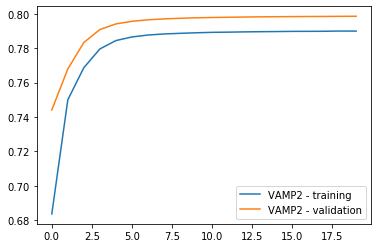

<IPython.core.display.Javascript object>

In [17]:
loss_vamp2_train = np.abs(training_log.history["loss"])
loss_vamp2_valid = np.abs(training_log.history["val_loss"])

xax = np.arange(len(loss_vamp2_train))

plt.plot(xax, loss_vamp2_train, label="VAMP2 - training")
plt.plot(xax, loss_vamp2_valid, label="VAMP2 - validation")
plt.legend()
plt.show()

Now we can finally reap the results of our work: if the network was properly trained it should automatically separate the two wells in our system. We can verify this hypothesis by first transforming our dataset with the network using the `model.predict` method.
**Note: don't forget to whiten the data!!**

In [18]:
transformed_data_both_lobes = model.predict(
    [whiten(data), whiten(data)], batch_size=data.shape[0]
)

# We discard half of the data as it is redundant
transformed_data = transformed_data_both_lobes[:, :output_size]

<IPython.core.display.Javascript object>

Now we can visualize to which states the network assigns every point; we do so in the following cell by calculating to which state every datapoint is most likely to be assigned by the network:

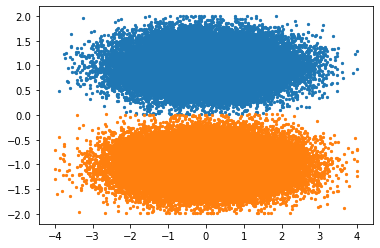

<IPython.core.display.Javascript object>

In [19]:
maxi_train = np.max(transformed_data, axis=1)
coor_train = np.zeros_like(transformed_data)
for i in range(output_size):
    coor_train = np.where(transformed_data[:, i] == maxi_train)[0]
    plt.scatter(data[coor_train, 0], data[coor_train, 1], s=5)
plt.show()

If you are looking at an orange and a blue ball, your network reached its optimal state during the training. <br>
We can further analyze the output of the network by visualizing what is the value of each output node of the network for each datapoint:

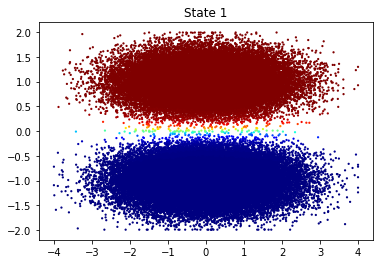

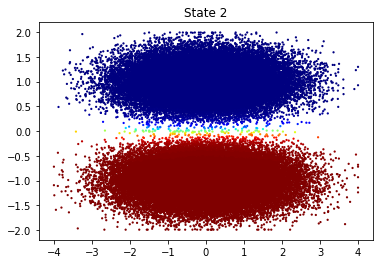

<IPython.core.display.Javascript object>

In [20]:
for i_state in range(output_size):
    plt.scatter(
        x=data[:, 0], y=data[:, 1], s=5, c=transformed_data[:, i_state], edgecolor=""
    )
    plt.title(f"State {i_state+1}")
    plt.show()

Since this is a very simple system, the network should enforce a very sharp classification, with most of the points belonging to either `state 1` or `state 2`, with only a few points in between having a mixed value.<br><br>
As a last step, we can verify that the network preserves the slow information in the system by plotting the implied timescales present in our transformed data using the convenient function in the `help_vampnets` file:

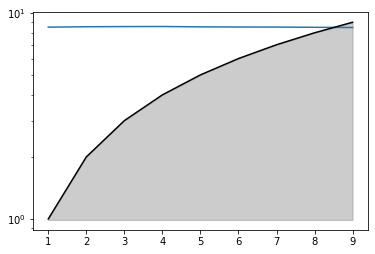

<IPython.core.display.Javascript object>

In [21]:
its = vn.get_its(transformed_data, np.arange(1, 10), plot=True)

## Hands-on session: Alanine Dipeptide
In the following three cells, you are given the loading function for the alanine-dipeptide trajectories (along with its 2 dihedral values), a plot that shows how to visualize information about the molecule using the dihedral data, and a set of hyperparameters. Build and train a network that classifies alanine samples, and set the number of epochs so that your network converges to a stable score. Plot your results and confront them to the provided examples.

#### Cell 1: Loading
**NOTE: do NOT use the dihedral information for the training! It would be easier to do so, but the interesting aspect of this exercise lies in seeing how easily the network extracts a low level representation from a highly dimensional space**

In [22]:
ala_coords_file = mdshare.fetch(
    "alanine-dipeptide-3x250ns-heavy-atom-positions.npz", working_directory="data"
)
with np.load(ala_coords_file) as fh:
    data = fh["arr_0"]

dihedral_file = mdshare.fetch(
    "alanine-dipeptide-3x250ns-backbone-dihedrals.npz", working_directory="data"
)
with np.load(dihedral_file) as fh:
    dihedral = fh["arr_0"]

<IPython.core.display.Javascript object>

#### Cell 2: Visualization
Since the dynamics of the molecule are completely described by its position in the dihedral plane, we can use these two variables 

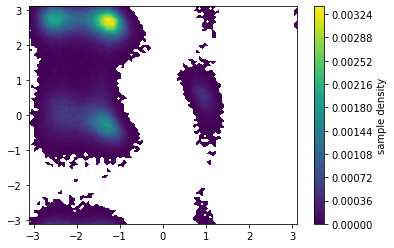

<IPython.core.display.Javascript object>

In [23]:
pyemma.plots.plot_density(*dihedral.T, cmap="viridis")
plt.show()

#### Cell 3: Hyperparameters
The `nb_epochs` variable is missing a value. Experiment with the training and find a number of epochs that ensures that your network will converge every time you train it

In [24]:
tau = 1

batch_size = 2000

train_ratio = 0.9

network_depth = 6

layer_width = 100

learning_rate = 3e-5

output_size = 6

nb_epoch = ##FIXME

<IPython.core.display.Javascript object>

In [36]:
transformed_data = model.predict(
    [whiten(data), whiten(data)], batch_size=data.shape[0]
)[:, :output_size]

<IPython.core.display.Javascript object>

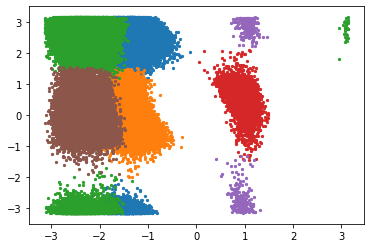

<IPython.core.display.Javascript object>

In [37]:
maxi_train = np.max(transformed_data, axis=1)
coor_train = np.zeros_like(transformed_data)
for i in range(output_size):
    coor_train = np.where(transformed_data[:, i] == maxi_train)[0]
    plt.scatter(*dihedral[coor_train].T, s=5)
plt.show()

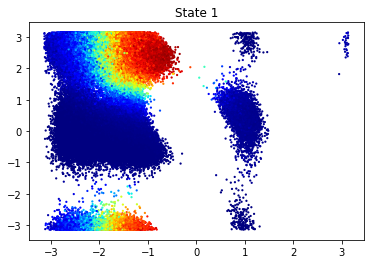

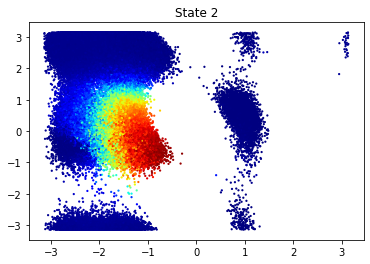

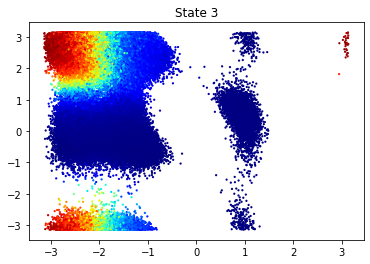

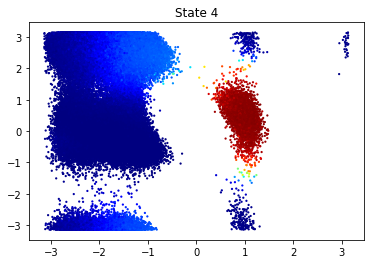

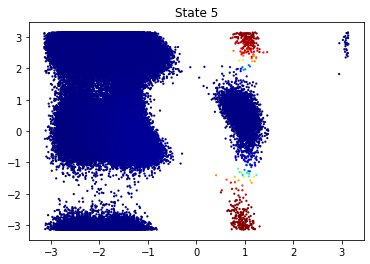

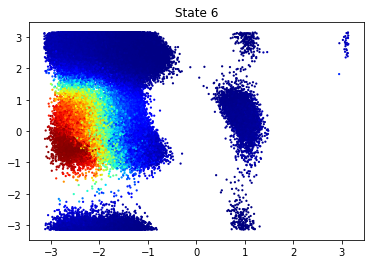

<IPython.core.display.Javascript object>

In [38]:
for i_state in range(output_size):
    plt.scatter(
        x=dihedral[:, 0],
        y=dihedral[:, 1],
        s=5,
        c=transformed_data[:, i_state],
        edgecolor="",
    )
    plt.title(f"State {i_state+1}")
    plt.show()

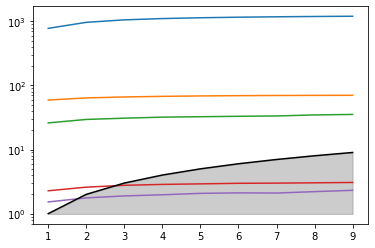

<IPython.core.display.Javascript object>

In [41]:
its = vn.get_its(transformed_data, np.arange(1, 10), plot=True)